In [2]:
# 201013
import numpy as np
import pandas as pd
from scipy import stats # 이상치 처리
# from sklearn.preprocessing import StandardScaler # 이상치에 덜 민감하지만 스케일에 차이가 다소 생긴다
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# 분류 뿐만 아니라 Regression 처리를 할 때도 KNN을 활용할 수 있다.
# Logistic일 경우 k값을 홀수로 설정한다.
# KNeighborsClassifier -> 0, 1 Regression
# KNeighborsRegressor -> 예측해서 결측치 채우기
import warnings

warnings.filterwarnings(action='ignore') # waring 출력을 하지 않는다.

# Raw Data Loading
df = pd.read_csv('./data/ozone.csv')

training_data = df

x_data = training_data[['Solar.R', 'Wind', 'Temp']] # 독립변수 
t_data = training_data['Ozone'] # 종속 변수

# 결측치 확인
# df.isnull().sum()  # Solar.R     7

# 1. 독립변수에 대한 결측치를 처리
#   Solar.R에 7개의 결측치가 있는데 median으로 처리한다. (이상치 때문에 평균 사용x)
for col in x_data.columns:
    col_median = np.nanmedian(x_data[col]) # NaN이 있는 경우를 제외하고 median을 구한다.
    x_data[col].loc[x_data[col].isnull()] = col_median

# x_data.isnull().sum() # Solar.R    0 -> 결측치가 처리된 것을 확인한다.

# 2. 독립변수에 대한 이상치를 검출한 후, 이상치는 mean 처리
zscore = 1.8

for col in x_data.columns:
    outliers = x_data[col][np.abs(stats.zscore(x_data[col])) > zscore]
    # 이상치에 해당하지 않는 행과 현재 열(column)만 추출하여 평균을 구한다.
    col_mean = np.mean(x_data.loc[~x_data[col].isin(outliers), col]) 
    x_data.loc[x_data[col].isin(outliers), col] = col_mean # 이상치에 평균 적용
    
# 3. 정규화 진행

scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(x_data.values)
scaler_t.fit(t_data.values.reshape(-1, 1))

x_data_norm = scaler_x.transform(x_data) # 2차원
t_data_norm = scaler_t.transform(t_data.values.reshape(-1, 1)).ravel() 
# 스케일랑하려면 2차원으로 입력
# 나중에 사용은 1차원으로 -> ravel() 적용

# 4. 종속변수 (Ozone)에 대한 결측치는 KNN을 이용해서 예측값으로 imputation
# 학습에 사용될 x_data_train_norm, t_data_train_norm을 구한다.
x_data_train_norm = x_data_norm[~np.isnan(t_data_norm)]
t_data_train_norm = t_data_norm[~np.isnan(t_data_norm)]

# KNN 모델 생성 후 학습 진행
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(x_data_train_norm, t_data_train_norm)

# KNN predict
knn_predict = knn_regressor.predict(x_data_norm[np.isnan(t_data_norm)])
t_data_norm[np.isnan(t_data_norm)] = knn_predict

# 최종 데이터를 생성했다.
# x_data_norm
# t_data_norm

#################################################################

## Linear Regression

In [4]:
# 학습을 진행한다. -> Linear Regression

from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense # Input, Outut layer들
from tensorflow.keras.optimizers import SGD # Stochastic Gradient Descent

# 태양광, 바람, 온도 - 테스트 데이터로 Ozone량을 예측한다.
# scaler로 정규화 시키기 위해 2차원으로 test_data 준비
test_data = [[310, 15, 80]] 

### sklearn
sklearn_model = LinearRegression() # Model 생성
sklearn_model.fit(x_data_norm, t_data_norm) # Model에 데이터를 학습시킨다. 이때 입력값은 1차원이어야

# 테스트 데이터를 정규화시켜서 예측한다.
result = sklearn_model.predict(scaler_x.transform(test_data)).reshape(-1, 1)

# scaled된 결과를 원래 형태로 복구시킨다.
scaled_result = scaler_t.inverse_transform(result) 
print('sklearn의 결과 : {}'.format(scaled_result))

### Tensorflow 2.x

# 모델 생성
keras_model = Sequential()

# 레이어 추가
keras_model.add(Flatten(input_shape=(3,)))     # input layer
keras_model.add(Dense(1, activation='linear')) # Linear Layer, 하나는 결과 하나

# compile
keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                   loss='mse') # MSE(Mean Square Error, 평균제곱오차)

# 학습
keras_model.fit(x_data_norm,
                t_data_norm,
                epochs=5000,
                verbose=0)

# prediction
# 테스트 데이터를 정규화시켜서 예측한다.
result = sklearn_model.predict(scaler_x.transform(test_data)).reshape(-1, 1)

# scaled된 결과를 원래 형태로 복구시킨다.
scaled_result = scaler_t.inverse_transform(result) 
print('Tensorflow의 결과 : {}'.format(scaled_result))

# hidden layer만 추가하면 딥러닝

sklearn의 결과 : [[38.75927452]]
Tensorflow의 결과 : [[38.75927452]]


## Logistic Regression

In [5]:
# Logistic Regression에 대해서 sklearn과 Tensorflow 2.x 구현

# tiatic(kaggle) => logistic 문제 (결측치가 다수 있다.)

# feature engineering

%reset

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats

# Raw Data Loading
df = pd.read_csv('./data/titanic/train.csv')

# Feature Engineering

# 필요없는 column 삭제

df = df.drop(['PassengerId','Name','Ticket','Cabin','Fare'], axis=1, inplace=False)

# 하나로 합칠 수 있는 column 처리
df['Family'] = df['SibSp'] + df['Parch']
df.drop(['SibSp','Parch'], axis=1, inplace=True)

# 문자로 되어 있는 column을 숫자로 변환
sex_dict = { 'male' : 0, 'female' : 1 }
df['Sex'] = df['Sex'].map(sex_dict)

embarked_dict = {'S' : 0, 'C' : 1, 'Q' : 2}
df['Embarked'] = df['Embarked'].map(embarked_dict)

# # 결측치 처리
# Age에 177개의 결측치, Embarked에 결측치 2
# Age는 median, Embarked는 mode를 이용하여 결측치 처리
df.loc[df['Age'].isnull(),'Age'] = np.nanmedian(df['Age'].values)

mode_result = stats.mode(df['Embarked'],nan_policy='omit')[0].ravel()
# print('mode_result : {}'.format(mode_result))
df.loc[df['Embarked'].isnull(),'Embarked'] = mode_result[0]
print(df.isnull().sum())

# 이상치 확인
# zscore = 1.8

# for col in df.columns:
#     outliers = df.loc[np.abs(stats.zscore(df[col])) >= zscore,col]
#     print('Col : {}에 이상치 : {}개'.format(col,outliers.sum()))
#     print('outliers : {}'.format(outliers))
# 실제로 이상치가 검출되지만 사실값이기 때문에 수정하지 않음.

def age_category(age):
    if ((age >=0) & (age<25)):
        return 0
    elif ((age >=25) & (age<50)):
        return 1
    else:
        return 2

df['Age'] = df['Age'].map(age_category)    

#################################################

df
# data split

x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('Survived', axis=1, inplace=False), df['Survived'], test_size=0.3, random_state=0)

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

del x_data_train
del x_data_test

##################

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Survived    0
Pclass      0
Sex         0
Age         0
Embarked    0
Family      0
dtype: int64


In [6]:
## sklearn으로 모델 구현
sklearn_model = LogisticRegression() # model 생성
sklearn_model.fit(x_data_train_norm, t_data_train) # model 학습
sklearn_result = sklearn_model.score(x_data_test_norm, t_data_test)

print('sklearn의 정확도는 {}'.format(sklearn_result))
# sklearn의 정확도는 0.7947761194029851

## tensorflow 2.x로 구현
keras_model = Sequential()

# 입력되는 독렵변수의 갯수 입력 -> shape[1] 
keras_model.add(Flatten(input_shape=(x_data_train_norm.shape[1], ))) 
# Output Layer에 출력값이 몇개인지, Logistic이 몇개인지 -> 살았는지 죽었는지 0, 1로 하나만 출력됨
keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(optimizer=SGD(learning_rate=1e-3),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# 교차 엔트로피는 주로 분류 문제에서 많이 사용되는데,
# 특별히 예측 값이 참과 거짓 둘 중 하나인 형식일 때는 binary_crossentropy(이항 교차 엔트로피)를 씁니다. 
# 지금 구하고자 하는 것은 생존(1) 또는 사망(0) 둘 중 하나이므로 binary_crossentropy를 사용

result = keras_model.fit(x_data_train_norm,
                t_data_train,
                epochs=1000,
                verbose=0,
                validation_split=0.3) # batch x

keras_result = keras_model.evaluate(x_data_test_norm, t_data_test)

print('TF2.0의 정확도는 {}'.format(keras_result))

# TF2.0의 정확도는 [0.5007948546267268, 0.78731346]

sklearn의 정확도는 0.7947761194029851
268/268 [==============================] - 0s 28us/sample - loss: 0.5008 - accuracy: 0.7873
TF2.0의 정확도는 [0.5007948546267268, 0.78731346]


<class 'tensorflow.python.keras.callbacks.History'>
<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


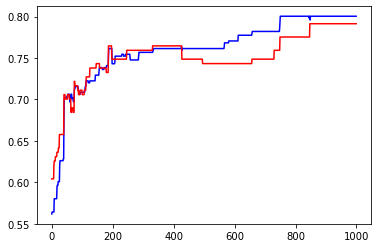

In [7]:
import matplotlib.pyplot as plt

print(type(result)) # 학습에 대한 정보들이 History라는 객체로 만들어진다.
print(type(result.history))
print(result.history.keys()) # ['loss', 'accuracy', 'val_loss', 'val_accuracy']

# epoch마다 loss와 accuracy, val_accuracy를 계산한다.
# epoch이 늘어나면서 오히려 accuracy가 떨어진다. 
plt.plot(result.history['accuracy'], color='b')
plt.plot(result.history['val_accuracy'], color='r')
plt.show()

# 같이 증가하다가 빨간색만 떨어지며 차이 발생 => Overfitting 발생
# training data에는 적용이 잘 되지만 validation에는 그렇지 않다.
# 같이 증가하는 지점까지가 오버피팅이 발생하지 않는 최적점이다. -> 그러나 accuracy가 너무 낮다.

## Multinomial Classification
* MNIST 예제

In [9]:
## Multinomial Classification

# sklearn과 TF 2.x로 구현한다.
# MNIST 예제로 구현

%reset

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression # multinomial 구현도 이거 이용
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Raw Data Loading
df = pd.read_csv('./data/mnist/train.csv')

# 결측치나 이상치가 없어 Feature Engineering은 하지 않는다.

# 독립변수와 종속변수 분리
x_data = df.drop('label', axis=1, inplace=False)
t_data = df['label'] # one-hot encoding해야하는데 일단 안함

# Normalization
scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

# Data Split
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(x_data_norm, t_data, test_size=0.3, random_state=0)

# 데이터가 준비되었으니 학습 진행

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [10]:
## sklearn
sklearn_model = LogisticRegression(solver='saga')

# solver라는 개념이 있는데, default로 사용되는건 lbfgs
# lbfgs : 작은 데이터셋에 좋다.
# 데이터량이 많은 경우 SAG (Stochastic Average Gradient Descent)를 이용
# 일반적으로는 이걸 개량한 saga를 더 많이 이용한다.

sklearn_model.fit(x_data_train, t_data_train) # 학습진행
print('sklearn result : ') 
print(classification_report(t_data_test, 
                            sklearn_model.predict(x_data_test)))

sklearn result : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1242
           1       0.95      0.97      0.96      1429
           2       0.92      0.90      0.91      1276
           3       0.91      0.90      0.91      1298
           4       0.92      0.92      0.92      1236
           5       0.88      0.88      0.88      1119
           6       0.93      0.96      0.94      1243
           7       0.94      0.93      0.94      1334
           8       0.89      0.88      0.88      1204
           9       0.89      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600



In [11]:
# TF 2.0 구현
keras_model = Sequential()
keras_model.add(Flatten(input_shape=(x_data_train.shape[1],)))
keras_model.add(Dense(10, activation='softmax'))

# 다중분류 -> categorical_crossentropy, t data를 one hot으로 입력해야
keras_model.compile(optimizer=SGD(learning_rate=1e-2),
                    loss='sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy'])

history = keras_model.fit(x_data_train,
                          t_data_train, 
                          epochs=500,
                          batch_size=100,
                          verbose=0,
                          validation_split=0.3)

print(keras_model.evaluate(x_data_test, t_data_test))
print('tensorflow result : ')

12600/12600 [==============================] - 0s 16us/sample - loss: 0.2887 - sparse_categorical_accuracy: 0.9199
[0.28872225853185807, 0.9199206]
tensorflow result : 


              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1242
           1       0.96      0.97      0.97      1429
           2       0.93      0.90      0.92      1276
           3       0.91      0.89      0.90      1298
           4       0.92      0.92      0.92      1236
           5       0.88      0.88      0.88      1119
           6       0.92      0.96      0.94      1243
           7       0.94      0.92      0.93      1334
           8       0.89      0.88      0.89      1204
           9       0.88      0.89      0.89      1219

    accuracy                           0.92     12600
   macro avg       0.92      0.92      0.92     12600
weighted avg       0.92      0.92      0.92     12600



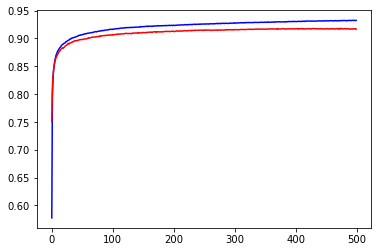

In [12]:
print(classification_report(t_data_test, 
                            (tf.argmax(keras_model.predict(x_data_test), axis=1)).numpy()))

# (tf.argmax(keras_model.predict(x_data_test), axis=1)).numpy()
import matplotlib.pyplot as plt

history.history.keys()
plt.plot(history.history['sparse_categorical_accuracy'], color='b')
plt.plot(history.history['val_sparse_categorical_accuracy'], color='r')
plt.show()